In [2]:
import pandas, numpy
import scipy, scipy.signal
import matplotlib, matplotlib.pyplot

In [3]:
matplotlib.rcParams.update({'font.size':20, 'xtick.labelsize':20, 'ytick.labelsize':20, 
                            'axes.grid' : True, 'grid.alpha': 0.5, 'grid.linestyle' : ':',
                            'figure.figsize':(12, 8), 'svg.fonttype' : 'none'})

In [4]:
input_file_directory = '/Users/kja11/OneDrive - Háskóli Íslands/PhD ATG7//0 in_silico/Python/1)data_input/'
output_file_directory = '/Users/kja11/OneDrive - Háskóli Íslands/PhD ATG7/0 in_silico/Python/3)output/'

In [5]:
path = output_file_directory + "ATG7/TCGA_GTEX/all_tissues/"
path2 = 'dataframes_for_input/'

In [6]:
%%time
# DL data gene expression for Normal Tissue and Primary Tumors
path = output_file_directory + "dataframes_for_input/"
protcoding_normal = pandas.read_csv(path+"ensembl_normal_protcoding_expr.tsv", sep = "\t")
protcoding_primary = pandas.read_csv(path+"ensembl_primary_protcoding_expr.tsv", sep = "\t")

for df in protcoding_normal, protcoding_primary:
    df.set_index('sample', inplace = True)

protcoding_normal = protcoding_normal.T
protcoding_primary = protcoding_primary.T
    
print(protcoding_normal.shape)
print(protcoding_primary.shape)

protcoding_primary.head()

(19382, 7429)
(19382, 9185)
Wall time: 3min 43s


sample,TCGA-02-0047-01,TCGA-02-0055-01,TCGA-02-2483-01,TCGA-02-2485-01,TCGA-04-1331-01,TCGA-04-1332-01,TCGA-04-1337-01,TCGA-04-1338-01,TCGA-04-1341-01,TCGA-04-1343-01,...,TCGA-ZP-A9D4-01,TCGA-ZQ-A9CR-01,TCGA-ZR-A9CJ-01,TCGA-ZS-A9CD-01,TCGA-ZS-A9CE-01,TCGA-ZS-A9CF-01,TCGA-ZS-A9CG-01,TCGA-ZT-A8OM-01,TCGA-ZU-A8S4-01,TCGA-ZX-AA5X-01
ENSG00000198888,12.920386,10.398268,11.694535,10.430545,14.069484,11.247293,13.430831,14.404566,12.395667,12.351376,...,14.122881,14.149479,12.713715,12.232300,12.464055,13.025373,12.100828,9.103023,11.357549,13.154958
ENSG00000198763,13.122162,10.778221,12.025246,10.518083,14.629057,10.893758,12.828698,14.866248,12.013249,12.478952,...,14.340869,14.552860,13.723207,11.795306,12.531943,13.249348,12.711915,8.416923,11.687737,13.120462
ENSG00000198804,14.013687,12.394768,13.115462,11.979057,14.281572,12.486651,14.489063,15.085541,12.395568,13.781902,...,14.396867,15.449332,13.898394,14.020387,14.084583,14.582059,13.973390,9.862349,12.407365,14.522361
ENSG00000198712,13.525222,12.389569,13.408733,11.614360,14.285772,11.943466,14.338870,14.108482,12.995077,13.855597,...,14.744952,14.156079,13.273246,13.605116,13.007075,13.967890,14.316671,11.007300,12.904388,14.541460
ENSG00000228253,13.843998,11.728425,13.628814,12.047740,13.898994,11.458412,13.495425,15.164139,11.962761,12.684919,...,15.057742,14.800151,13.996188,13.326440,13.355538,14.657256,13.876396,6.897242,12.643925,14.217176


In [7]:
#Download the filtered sample list
path = "samples_IDs/filtered_samples_list"

samples_list_normal= numpy.loadtxt(input_file_directory+path+'_normal.tsv', delimiter="\t", dtype=str)
samples_list_primary= numpy.loadtxt(input_file_directory+path+'_primary.tsv', delimiter="\t", dtype=str)

print(len(samples_list_normal), len(samples_list_primary))

5903 8022


In [8]:
# Only select the filtered samples
protcoding_normal = protcoding_normal[samples_list_normal]
protcoding_primary = protcoding_primary[samples_list_primary]

print('normal_tissue' , protcoding_normal.shape)
print('primary_tumors' , protcoding_primary.shape)

normal_tissue (19382, 5903)
primary_tumors (19382, 8022)


# Quantification

In [9]:
%%time
# quantile normalization 
# taken from https://cmdlinetips.com/2020/06/computing-quantile-normalization-in-python/

# NORMAL
# step 1/3: sorting sample values
df_sorted_norm = pandas.DataFrame(numpy.sort(protcoding_normal.values, axis=0), 
                             index=protcoding_normal.index, columns=protcoding_normal.columns)
# step 2/3: averaging rank values across samples
df_mean_norm = df_sorted_norm.mean(axis=1)
df_mean_norm.index = numpy.arange(1, len(df_mean_norm) + 1)
# step 3/3: re-ordering samples
quantif_df_norm = protcoding_normal.rank(method="min").stack().astype(int).map(df_mean_norm).unstack()

# same for PRIMARY
df_sorted_prim = pandas.DataFrame(numpy.sort(protcoding_primary.values, axis=0), 
                             index=protcoding_primary.index, columns=protcoding_primary.columns)
df_mean_prim = df_sorted_prim.mean(axis=1)
df_mean_prim.index = numpy.arange(1, len(df_mean_prim) + 1)
quantif_df_prim= protcoding_primary.rank(method="min").stack().astype(int).map(df_mean_prim).unstack()

Wall time: 2min 34s


15.179136886236856
0
15.179136886236856
0
Wall time: 32.7 s


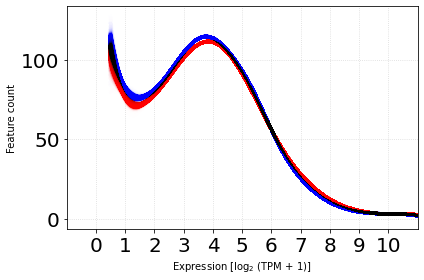

In [10]:
%%time
found_max = 15
resolution = 25
number_of_bins = found_max * resolution
absolute_max = 0
margin = int(resolution/2)

most_likely_expressions = []

selected_samples = []

dfs = quantif_df_norm, quantif_df_prim
colors = 'blue', 'red'

for i in range(len(dfs)):
    df = dfs[i]
    color_ = colors[i]
    
    for sample in df.columns:
        expression_values = df.loc[:, sample]

        # histogram
        hist, bin_edges = numpy.histogram(expression_values, bins=number_of_bins, range=(0, found_max))
        half_bin = (bin_edges[1] - bin_edges[0])/2
        x = bin_edges + half_bin
        x = x[:-1]

        # curve fitting
        plotting_x = x[margin:-margin]
        plotting_hist = hist[margin:-margin]
        yhat = scipy.signal.savgol_filter(plotting_hist, 51, 3)

        # determine most likely expression
        most_likely_expression = x[numpy.argmax(yhat)]
        most_likely_expressions.append(most_likely_expression)

        # sample selection
        if 1 <= most_likely_expression <= 2:
            selected_samples.append(sample)

        # plotting
        matplotlib.pyplot.plot(plotting_x, yhat, '-', lw=4, alpha=1/300, color=color_)

        # check
        if numpy.max(expression_values) > absolute_max:
            absolute_max = numpy.max(expression_values)

    # check print
    print(absolute_max)
    print(len(selected_samples))

    matplotlib.pyplot.xlim(-1, 11)                  
    matplotlib.pyplot.xticks(range(0, 10+1))
    matplotlib.pyplot.xlabel('Expression [log$_2$ (TPM + 1)]')
    matplotlib.pyplot.ylabel('Feature count')
    matplotlib.pyplot.grid(ls=':')
    matplotlib.pyplot.tight_layout()
#     matplotlib.pyplot.show()
#     matplotlib.pyplot.close()

## Convert expression to z-score

In [11]:
%%time
# zscore not working because min in zero
quantif_df_norm = quantif_df_norm+0.0000000000000000000000001
quantif_df_prim = quantif_df_prim+0.0000000000000000000000001
print(type(quantif_df_norm))
zscore_df_norm = scipy.stats.zscore(quantif_df_norm, axis=1)
zscore_df_prim = scipy.stats.zscore(quantif_df_prim, axis=1)
zscore_df_prim.std(axis=1)

<class 'pandas.core.frame.DataFrame'>
Wall time: 10.6 s


ENSG00000198888    1.000062
ENSG00000198763    1.000062
ENSG00000198804    1.000062
ENSG00000198712    1.000062
ENSG00000228253    1.000062
                     ...   
ENSG00000181817    1.000062
ENSG00000116885    1.000062
ENSG00000116898    1.000062
ENSG00000119535    1.000062
ENSG00000142694    1.000062
Length: 19382, dtype: float64

In [12]:
zscore_df_norm

sample,GTEX-1117F-0226-SM-5GZZ7,GTEX-1117F-0526-SM-5EGHJ,GTEX-1117F-0626-SM-5N9CS,GTEX-1117F-0726-SM-5GIEN,GTEX-1117F-1326-SM-5EGHH,GTEX-1117F-2226-SM-5N9CH,GTEX-1117F-2426-SM-5EGGH,GTEX-1117F-2826-SM-5GZXL,GTEX-1117F-3026-SM-5GZYU,GTEX-111CU-0126-SM-5GZWZ,...,GTEX-ZZPU-0326-SM-5N9BJ,GTEX-ZZPU-0526-SM-5E44U,GTEX-ZZPU-0726-SM-5N9C8,GTEX-ZZPU-0926-SM-5GZYT,GTEX-ZZPU-1226-SM-5N9CK,GTEX-ZZPU-1326-SM-5GZWS,GTEX-ZZPU-1826-SM-5E43L,GTEX-ZZPU-2126-SM-5EGIU,GTEX-ZZPU-2226-SM-5EGIV,GTEX-ZZPU-2726-SM-5NQ8O
ENSG00000198888,1.190884,0.898610,-0.272200,-0.031037,0.898610,-3.494575,-1.226637,1.333401,0.898610,0.641517,...,0.765988,0.352102,-1.652882,0.765988,0.641517,-0.031037,0.352102,-0.272200,-1.038047,0.898610
ENSG00000198763,-0.277555,-0.774308,0.625942,-0.074143,0.625942,-4.268193,0.259062,0.625942,-0.074143,0.431011,...,0.097681,0.097681,-2.623235,-0.277555,0.259062,-0.074143,0.097681,-0.074143,-1.938165,0.809955
ENSG00000198804,-0.152273,-0.800803,-2.507672,0.295997,-1.238498,-3.555058,-2.701759,-0.152273,0.532137,0.532137,...,0.413822,0.413822,-1.116376,0.829227,0.829227,0.829227,0.413822,0.295997,0.061081,0.532137
ENSG00000198712,-0.802258,-0.601867,-1.885034,-0.388352,-0.802258,-6.763979,-2.885276,-0.802258,0.082193,0.082193,...,0.571510,0.311639,-3.506269,0.311639,0.082193,-0.146301,0.571510,-0.802258,0.082193,-0.146301
ENSG00000228253,0.462616,0.462616,0.462616,0.462616,0.462616,-1.259366,0.462616,0.462616,0.462616,0.462616,...,0.462616,0.462616,-2.288038,0.462616,0.462616,0.462616,0.462616,0.462616,-0.690261,0.462616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000181817,0.281347,-0.427080,-0.233564,0.652185,0.041929,-0.461029,-0.701430,-0.524776,-0.644546,-0.831898,...,0.747777,0.121299,-0.408018,1.004721,-1.073251,-1.248241,1.492586,-0.877655,-1.411929,0.238471
ENSG00000116885,-0.169428,-0.704039,-0.889340,0.005941,-1.035634,0.200859,0.284168,-0.608029,0.472487,-0.025203,...,0.273572,0.442775,-0.126758,-0.041260,0.132055,1.113605,0.382299,0.771601,-0.888289,-0.143069
ENSG00000116898,-0.689030,-1.641740,-0.537283,-0.019630,-0.671648,-1.173191,-1.491904,-0.140470,-0.843565,0.376832,...,1.112225,-0.343217,-0.011414,1.618992,0.379578,-0.901591,0.416634,-1.844973,0.149571,1.152540
ENSG00000119535,0.609651,-0.252226,0.359816,0.871017,1.016719,1.191034,0.096552,1.337190,0.387167,-0.071366,...,2.001639,2.528781,-0.492898,0.033246,0.022129,-0.217073,-0.670268,-0.763683,-1.013470,0.645045


In [13]:
print(zscore_df_norm.max().max())
print(zscore_df_norm.min().min())

print(zscore_df_prim.max().max())
print(zscore_df_prim.min().min())

76.82447526667526
-16.398025060598243
89.56003573022957
-12.339115882962048


In [14]:
#save to csv
path = 'dataframes_for_input/'
zscore_df_norm.to_csv(output_file_directory+path+'zscore_df_norm.tsv',sep = "\t")
zscore_df_prim.to_csv(output_file_directory+path+'zscore_df_prim.tsv',sep = "\t")